## Idiopathic Scoliosis
Scoliosis is a medical condition characterized by an abnormal curvature of the spine, typically in an "S" or "C" shape when viewed from the front or back. It can develop in both children and adults and may be caused by various factors, including genetics, muscle imbalances, or structural issues.

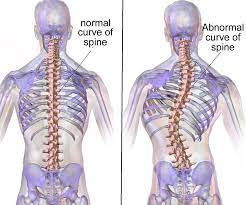

Using X-ray image to detect Scoliosis
Convolutional Neural Networks (CNNs) are valuable tools in the medical field, particularly in the context of processing X-ray images and classifying conditions like scoliosis. They automate the detection of abnormalities, enhance diagnostic accuracy, speed up the diagnosis process, assist in severity assessment, and support medical research efforts for improved patient care and outcomes.

## Problem Statement:
Distinguishing between X-ray images that display a healthy spine and those that exhibit scoliosis, characterized by spinal curvature.

## Dataset
Obtaining medical data, particularly X-ray images, is often challenging. In this project, we sourced our dataset from [https://data.mendeley.com/datasets/xkt857dsxk/1] Due to the limited availability of such data, Data augmentation techniques to create synthetic data for our study.

There are two directories, one labeled "NORMAL" and the other "SCOLIOSIS," each containing images corresponding to their respective categories.

### 1. Importing Libraries

In [187]:
import numpy as np
import os
import glob
import cv2
import pandas as pd
from keras import backend as K
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from tensorflow.keras import layers, models, datasets
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,log_loss,ConfusionMatrixDisplay,f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer, Flatten, Dense, Dropout,Input,GlobalAveragePooling2D

plt.rcParams['figure.figsize'] = (20,8)
import warnings
warnings.filterwarnings("ignore")

### 2. Loading Images in Dataframe

In [188]:
normal = '/kaggle/input/scoliosis/Scoliosis_Dataset/224/Normal'
scoliosis = '/kaggle/input/scoliosis/Scoliosis_Dataset/224/Scol'
normal_images = os.listdir(normal)
scol_images = os.listdir(scoliosis)

df = pd.DataFrame({
    'class': ["NORMAL"]* len(normal_images) + ["SCOLIOSIS"]* len(scol_images),
    'path': [os.path.join(normal, fname) for fname in normal_images] + 
            [os.path.join(scoliosis, fname) for fname in scol_images]})

In [189]:
df.head()

,class,path
0,NORMAL,/kaggle/input/scoliosis/Scoliosis_Dataset/224/...
1,NORMAL,/kaggle/input/scoliosis/Scoliosis_Dataset/224/...
2,NORMAL,/kaggle/input/scoliosis/Scoliosis_Dataset/224/...
3,NORMAL,/kaggle/input/scoliosis/Scoliosis_Dataset/224/...
4,NORMAL,/kaggle/input/scoliosis/Scoliosis_Dataset/224/...


In [190]:
df = df.sample(frac=1).reset_index(drop=True)

In [191]:
df.shape

(259, 2)

In [192]:
df['class'].value_counts()

class
SCOLIOSIS    188
NORMAL        71
Name: count, dtype: int64

### 3. Visualizing Images

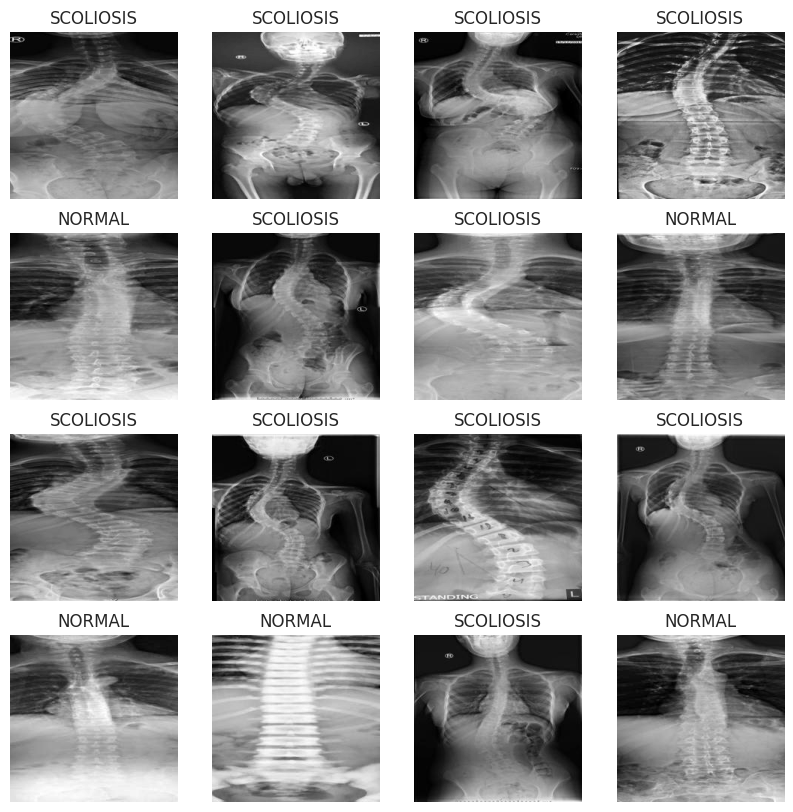

In [193]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
random = df.sample(16)

for idx, ax in enumerate(axs.ravel()):
    img = cv2.imread(random.iloc[idx]['path'], cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap= 'gray')
    ax.set_title(random.iloc[idx]['class'])
    ax.axis('off')
    
plt.show()

* Looking at the X-ray pictures, we can see that in scoliosis, the spine is shaped like an "S" or "C," curving to the side. But in a regular, healthy spine, it looks straight without any curves or bends

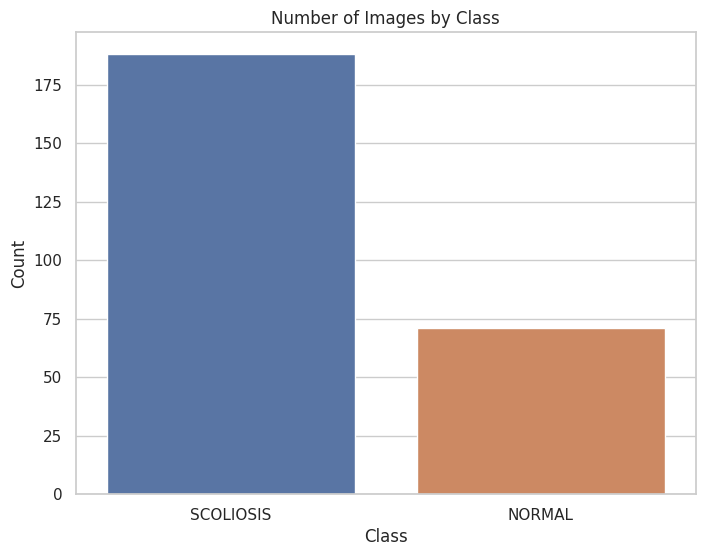

In [194]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.barplot(x=df['class'].value_counts().index, y=df['class'].value_counts().values)
plt.title("Number of Images by Class");
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### 4. Data Augmentation using Image Data Generator

* ImageDataGenerator is useful for augmenting the images dataset. Different tranformations techniques can be used to enhance the model performance and overcome the problem of overfitting.

In [195]:
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range= 15,
    brightness_range=[0.2,1.2],
    height_shift_range=0.13,
    width_shift_range = 0.13,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='training',
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.2)

validation_generator = validation_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation',
    shuffle = False)

Found 208 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [239]:
a = 0
b= 0
for label in train_generator.labels:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
print (f'Number of Normal images in test data = {a}')
print (f'Number of Scoliosis images in test data= {b}')
print(f'Total number of images = {a+b}')

Number of Normal images in test data = 60
Number of Scoliosis images in test data= 148
Total number of images = 208


## 

In [196]:
img_size = 224
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(img_size,img_size,1), activation = 'relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3),activation = 'relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), activation = 'relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [197]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 28, 28, 128)    

### 6.Training the Model

In [198]:
epochs = 8
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10
7/7 [==============================] - 3s 196ms/step - loss: 1.0093 - accuracy: 0.5337 - val_loss: 0.4903 - val_accuracy: 0.7843
Epoch 2/10
7/7 [==============================] - 1s 182ms/step - loss: 0.5817 - accuracy: 0.7115 - val_loss: 0.5376 - val_accuracy: 0.7843
Epoch 3/10
7/7 [==============================] - 1s 177ms/step - loss: 0.5411 - accuracy: 0.7115 - val_loss: 0.4533 - val_accuracy: 0.7843
Epoch 4/10
7/7 [==============================] - 1s 178ms/step - loss: 0.5288 - accuracy: 0.7115 - val_loss: 0.3914 - val_accuracy: 0.7843
Epoch 5/10
7/7 [==============================] - 1s 181ms/step - loss: 0.4672 - accuracy: 0.7212 - val_loss: 0.4867 - val_accuracy: 0.7647
Epoch 6/10
7/7 [==============================] - 1s 183ms/step - loss: 0.5047 - accuracy: 0.7548 - val_loss: 0.3765 - val_accuracy: 0.8235
Epoch 7/10
7/7 [==============================] - 1s 187ms/step - loss: 0.4772 - accuracy: 0.7644 - val_loss: 0.3618 - val_accuracy: 0.8039
Epoch 8/10
7/7 [====

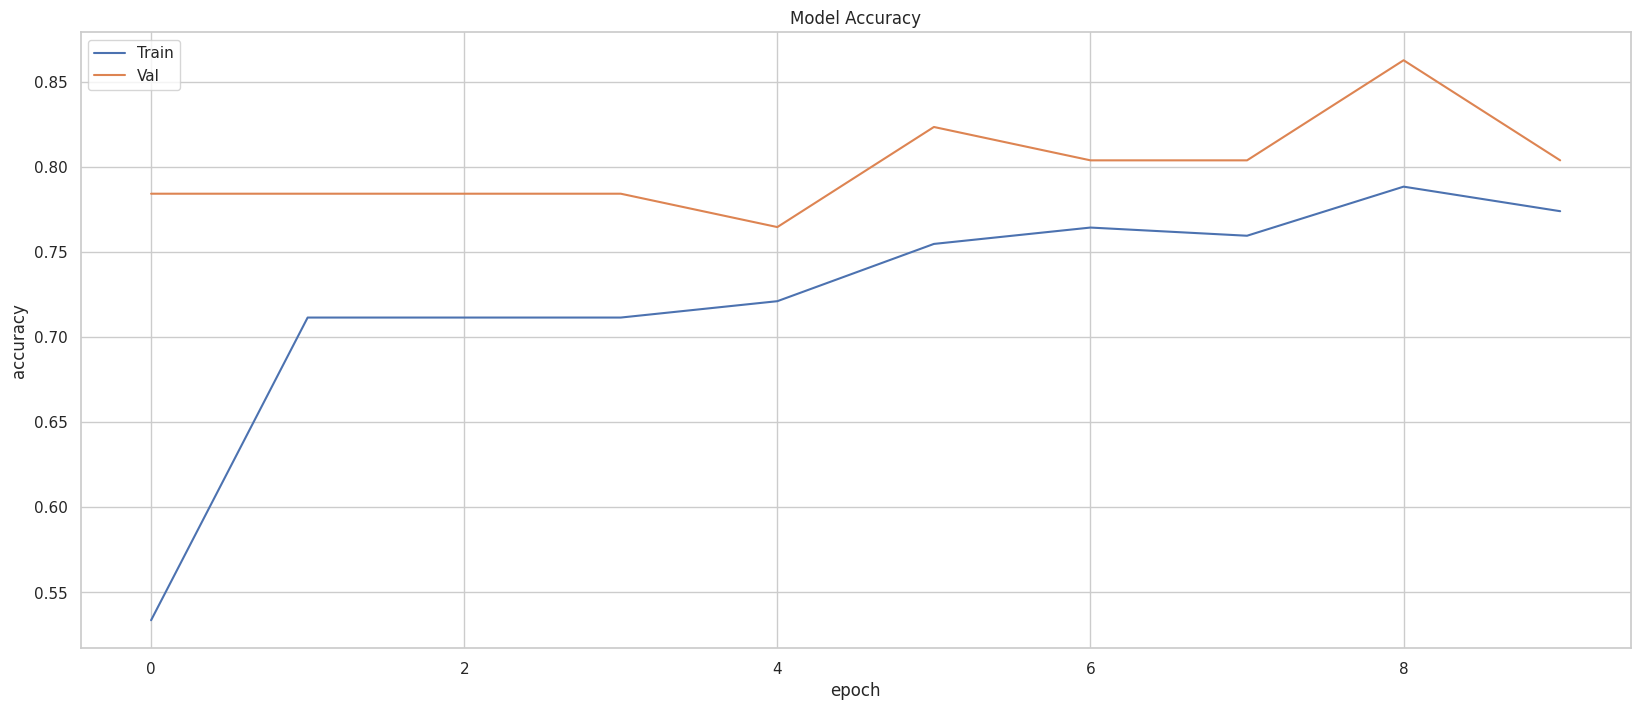

In [235]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


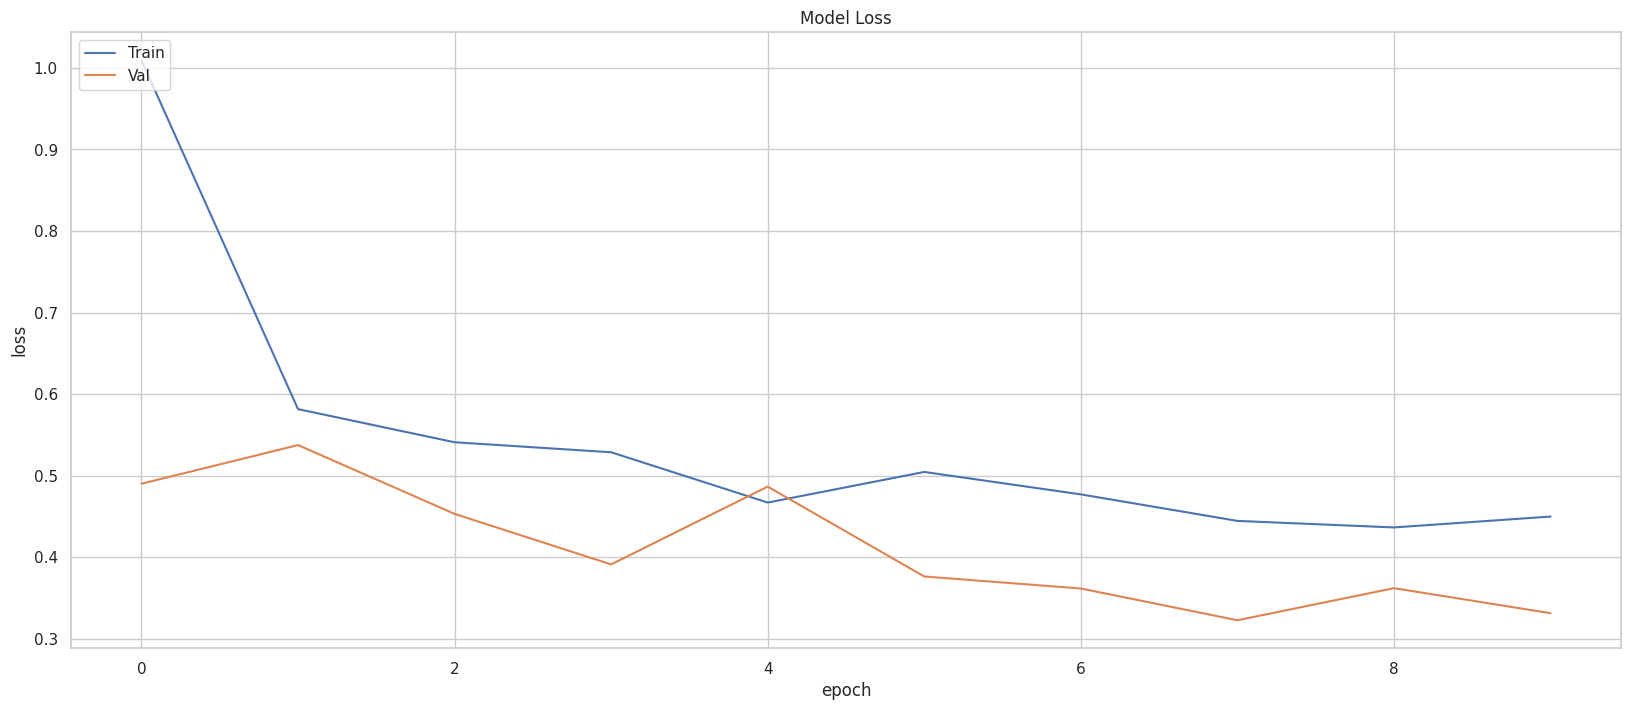

In [200]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [213]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_probs = y_pred.copy()

2/2 [==============================] - 0s 30ms/step


In [214]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

In [238]:
print(classification_report(y_test,y_pred,target_names = ['Normal','Scoliosis']))

              precision    recall  f1-score   support

      Normal       0.64      0.82      0.72        11
   Scoliosis       0.95      0.88      0.91        40

    accuracy                           0.86        51
   macro avg       0.79      0.85      0.81        51
weighted avg       0.88      0.86      0.87        51



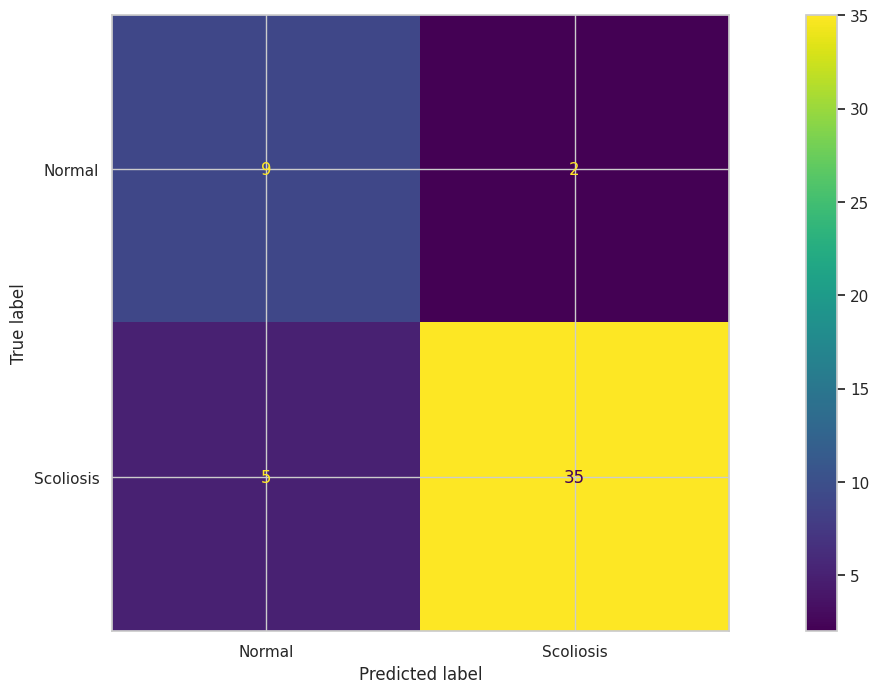

In [236]:
cm = confusion_matrix(y_test, y_pred )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Normal','Scoliosis'])
disp.plot()

In [237]:
ac = accuracy_score(y_test,y_pred)
print(f" The accuracy is {ac}")

 The accuracy is 0.8627450980392157


* With a larger dataset, we could have explored different pre-trained networks to assess model accuracy. The 88% recall for scoliosis is achieved with accuracy 86%. Misclassifying scoliosis as normal could have serious consequences, especially if there were more scoliosis cases that went undetected.